## Setup

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
import numpy as np 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm

## Utility functions

The block below is used to define the function to identify the stock return prediction trend accuracy 

In [4]:
def plot_model_performance(y_pred, y_test):

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    columns = ['Accuracy', 'Precision', 'Recall', 'F1 score']
    data = [accuracy, precision, recall, f1]
    df_metrics = pd.DataFrame(data=data, index=columns, columns=['metrics'])

    # Plot metrics
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Bar plot for metrics
    axes[0].bar(df_metrics.index, df_metrics['metrics'], color='grey')
    axes[0].set_xlabel('Metrics', fontsize=14)
    axes[0].set_ylabel('Scores', fontsize=14)
    axes[0].set_title('Model Performance Metrics', fontsize=20, fontweight='bold')
    axes[0].set_ylim(0, 1)
    for bar in axes[0].patches:
        height = bar.get_height()
        axes[0].annotate(f'{height:.2f}', 
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

    # Confusion matrix
    dt_cf = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(dt_cf).plot(ax=axes[1], cmap='coolwarm')
    axes[1].set_title('Confusion Matrix', fontsize=20, fontweight='bold')

    plt.tight_layout()
    plt.show()

##  Data loading 
The block below is used to get the stock data and choose the desired features and rows. The code will also change the dataframe index to datetime for future analysis.

In [7]:
apple_stock = yf.download('AAPL') 
apple_stock.drop(columns=['Open', 'High', 'Low', 'Close'], axis=1, inplace=True)
apple_stock.index = pd.to_datetime(apple_stock.index)
apple_stock = apple_stock[apple_stock.index > '2010-01-01']
apple_stock.index = pd.to_datetime(apple_stock.index)

[*********************100%%**********************]  1 of 1 completed


## Add the return columns (5-day, volume daily change)

In [16]:
apple_stock['5-Day Return'] = apple_stock['Adj Close'].pct_change(5) * 100
apple_stock['5-Day volume change'] = apple_stock['Volume'].pct_change(5) * 100
apple_stock = apple_stock.dropna()

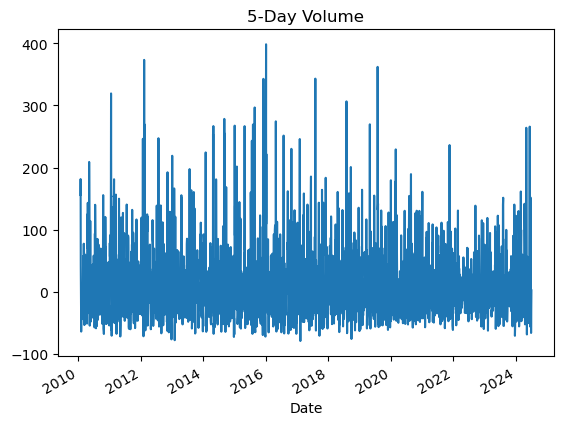

In [17]:
apple_stock['5-Day volume change'].plot()
plt.title('5-Day Volume');

The code below will be used to test the stationary of the daily volume change data

In [12]:
result = adfuller(apple_stock['1-Day volume change'])

# Extract and print the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -30.058822084644284
p-value: 0.0


 As we can see above, after the adfuller hypothesis test, the p_value is smaller that 0.05, which means that we have enough evidence to reject the null hypothesis and agree that the series is stationary. We plot the return data in the figrue below.

In [18]:
train = apple_stock[apple_stock.index <= '2024-01-01']
test = apple_stock[apple_stock.index > '2024-01-01']
print(f'Train set size: {train.shape}')
print(f'Test set size: {test.shape}')

Train set size: (3507, 5)
Test set size: (126, 5)


In [ ]:
model5 = SARIMAX(train['5-Day Return'], order=(7, 0, 0), exog= train['5-Day volume change'])
model5_fit = model5.fit()
print(model5_fit.summary())

In [58]:
history = train['5-Day Return'].tolist() 
exog_history = train['5-Day volume change'].tolist()
predictions = []
threshold_5days = []


for t in tqdm(range(len(test)), desc="Processing"):  # Adjust the range to avoid index error

    model = SARIMAX(history[-500:], order=(7, 0, 0), exog=exog_history[-500:])
    model_fit = model.fit(maxiter=1000) 
    # exog_forecast = [[test['5-Day volume change'].iloc[t]]] * 5
    exog_forecast = [[exog_history[-1]]] * 5
    output = model_fit.forecast(steps=5, exog=exog_forecast)
    yhat = output[-1]
    predictions.append(yhat)

    if len(history) >= 5:
        moving_avg_5days = pd.Series(history[-5:]).mean()
        moving_std_5days = pd.Series(history[-5:]).std()
        threshold_5days.append(moving_avg_5days + moving_std_5days)

    obs = test['5-Day Return'].iloc[t]
    obs_exo = test['5-Day volume change'][t]
    history.append(obs)
    exog_history.append(obs_exo)

Processing: 100%|██████████| 126/126 [00:52<00:00,  2.41it/s]


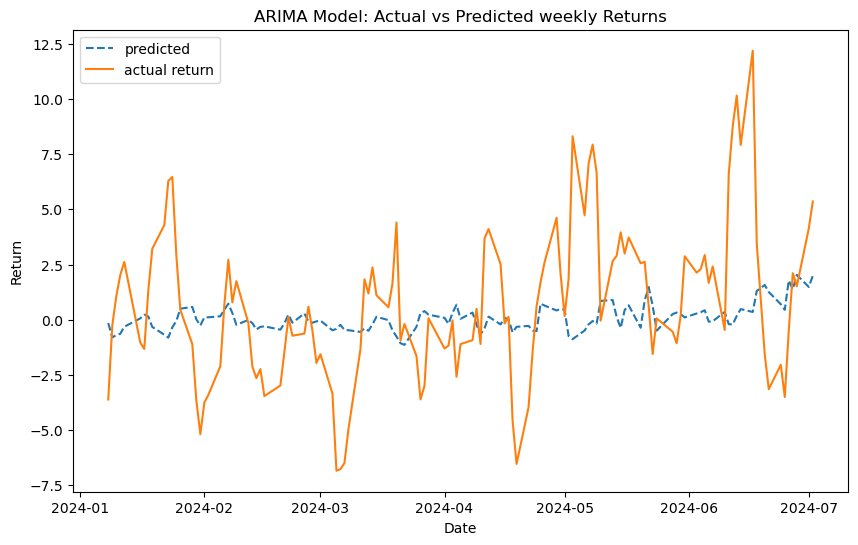

In [59]:
df5 = pd.DataFrame(data=predictions, index=test.index, columns=['predicted return difference compared with today'])
df5['predicted return difference compared with today_corrected'] = df5['predicted return difference compared with today'].shift(4)
df5['real return'] =  test['5-Day Return']
df5['threshold'] = threshold_5days
df5['threshold'] = df5['threshold'].shift(4)
df5.dropna(inplace=True, axis=0)

plt.figure(figsize = (10,6))
plt.plot(df5['predicted return difference compared with today_corrected'], linestyle = '--', label = 'predicted')
plt.plot(df5['real return'], label = 'actual return')
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('ARIMA Model: Actual vs Predicted weekly Returns')
plt.legend()
plt.show()

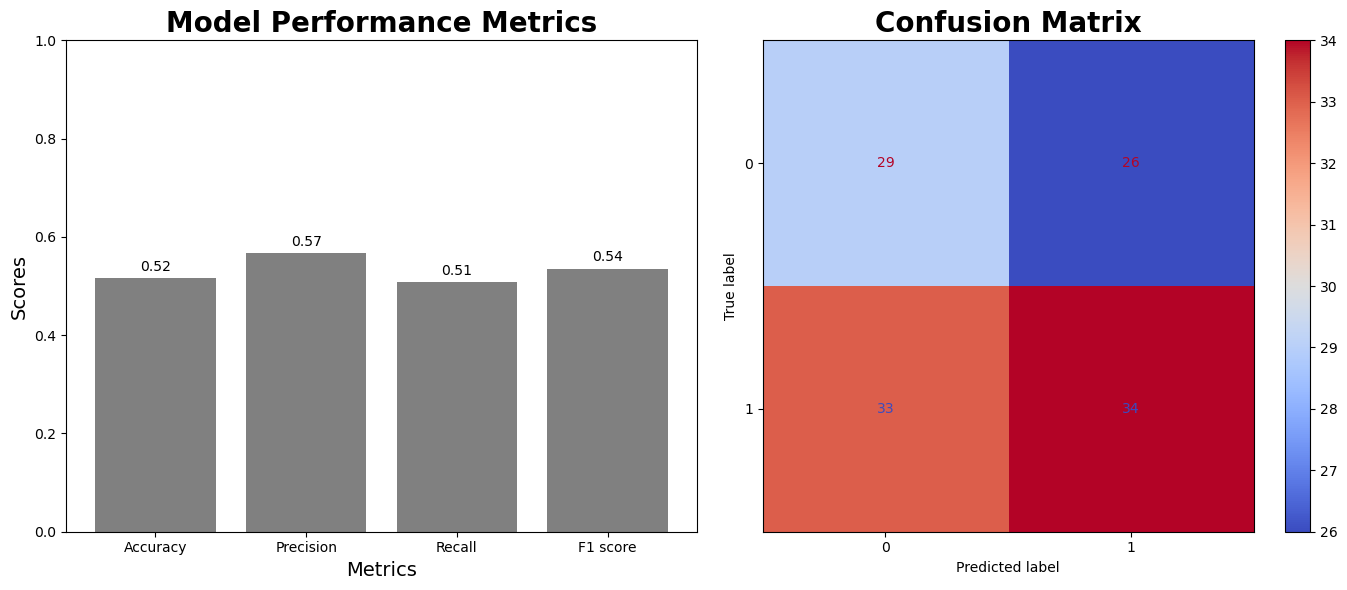

In [60]:
df5['predicted binary'] = np.where((df5['predicted return difference compared with today_corrected'] >0), 1, 0)
df5['actual binary'] = np.where(df5['real return']>0, 1, 0)
plot_model_performance(df5['predicted binary'], df5['actual binary'])

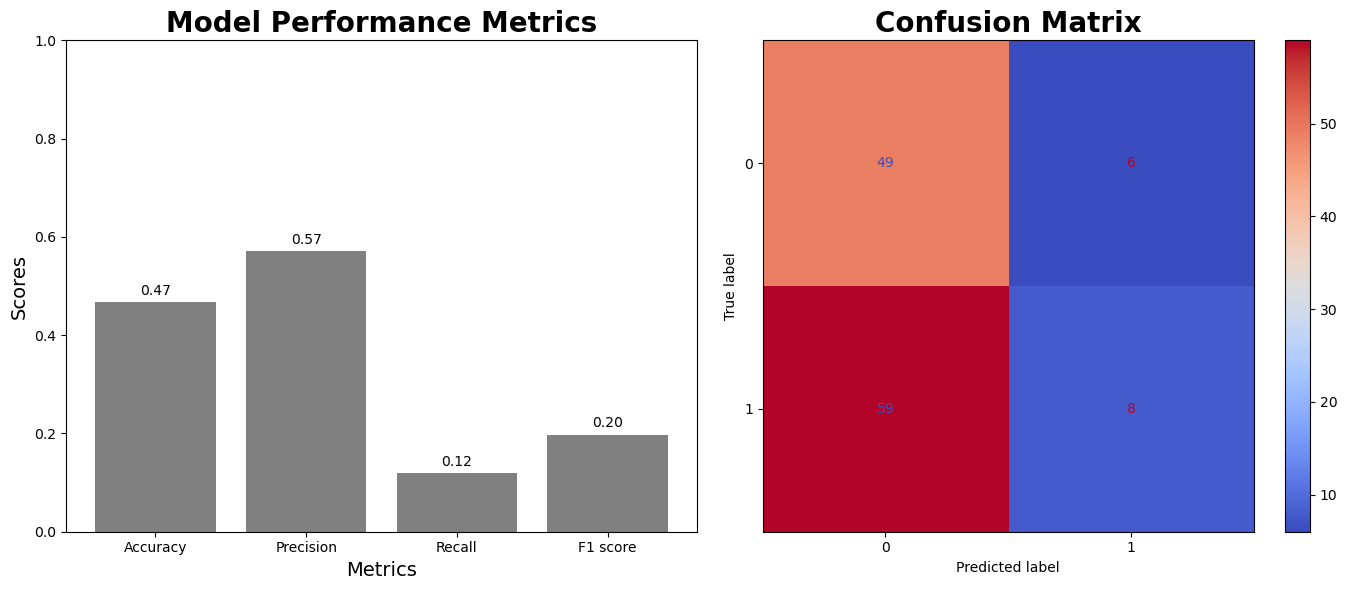

In [61]:
df5['predicted binary'] = np.where((df5['predicted return difference compared with today_corrected'] >0) & (df5['predicted return difference compared with today_corrected']>df5['threshold']), 1, 0)
# df5['predicted binary'] = np.where((df5['predicted return difference compared with today_corrected'] >0), 1, 0)
df5['actual binary'] = np.where(df5['real return']>0, 1, 0)
plot_model_performance(df5['predicted binary'], df5['actual binary'])

## Validation Section 

I will use the 5 day moving-window method to check the performance of my method.

In [62]:
train = apple_stock[apple_stock.index <= '2013-02-01']
test = apple_stock[apple_stock.index > '2013-02-01']
print(f'Train set size: {train.shape}')
print(f'Test set size: {test.shape}')

Train set size: (761, 5)
Test set size: (2872, 5)


In [64]:
history = train['5-Day Return'].tolist() 
exog_history = train['5-Day volume change'].tolist()
predictions = []
threshold_5days = []


for t in tqdm(range(len(test)), desc="Processing"):  # Adjust the range to avoid index error

    model = SARIMAX(history[-600:], order=(3, 0, 0), exog=exog_history[-600:])
    model_fit = model.fit(maxiter=1000) 
    # exog_forecast = [[test['5-Day volume change'].iloc[t]]] * 5
    exog_forecast = [[exog_history[-1]]] * 5
    output = model_fit.forecast(steps=5, exog=exog_forecast)
    yhat = output[-1]
    predictions.append(yhat)

    if len(history) >= 5:
        moving_avg_5days = pd.Series(history[-5:]).mean()
        moving_std_5days = pd.Series(history[-5:]).std()
        threshold_5days.append(moving_avg_5days + moving_std_5days)

    obs = test['5-Day Return'].iloc[t]
    obs_exo = test['5-Day volume change'][t]
    history.append(obs)
    exog_history.append(obs_exo)

Processing:  20%|██        | 583/2872 [02:06<10:14,  3.73it/s]c:\Users\12436\.conda\envs\Capstones\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Processing:  25%|██▌       | 722/2872 [02:38<10:07,  3.54it/s]c:\Users\12436\.conda\envs\Capstones\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Processing:  28%|██▊       | 815/2872 [03:07<09:51,  3.48it/s]c:\Users\12436\.conda\envs\Capstones\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Processing:  29%|██▉       | 847/2872 [03:19<09:44,  3.46it/s]c:\Users\12436\.conda\envs\Capstones\lib\

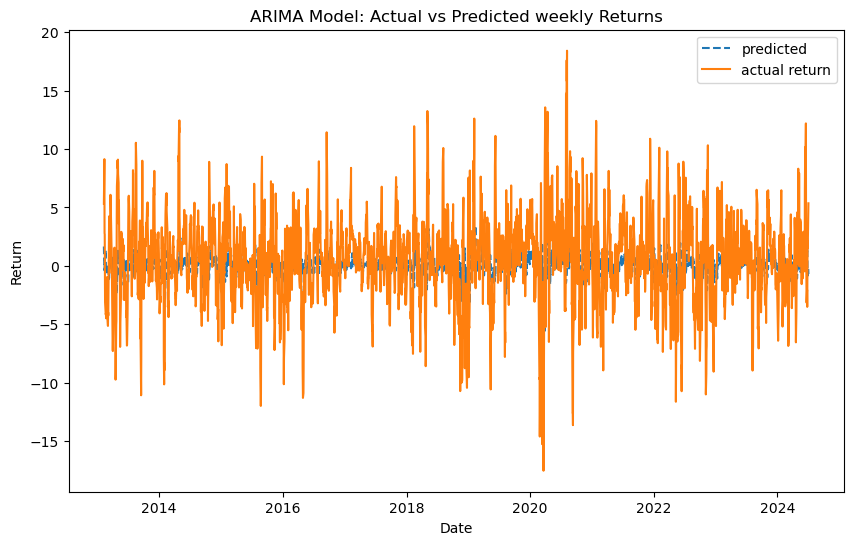

In [65]:
df5 = pd.DataFrame(data=predictions, index=test.index, columns=['predicted return difference compared with today'])
df5['predicted return difference compared with today_corrected'] = df5['predicted return difference compared with today'].shift(4)
df5['real return'] =  test['5-Day Return']
df5['threshold'] = threshold_5days
df5['threshold'] = df5['threshold'].shift(4)
df5.dropna(inplace=True, axis=0)

plt.figure(figsize = (10,6))
plt.plot(df5['predicted return difference compared with today_corrected'], linestyle = '--', label = 'predicted')
plt.plot(df5['real return'], label = 'actual return')
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('ARIMA Model: Actual vs Predicted weekly Returns')
plt.legend()
plt.show()

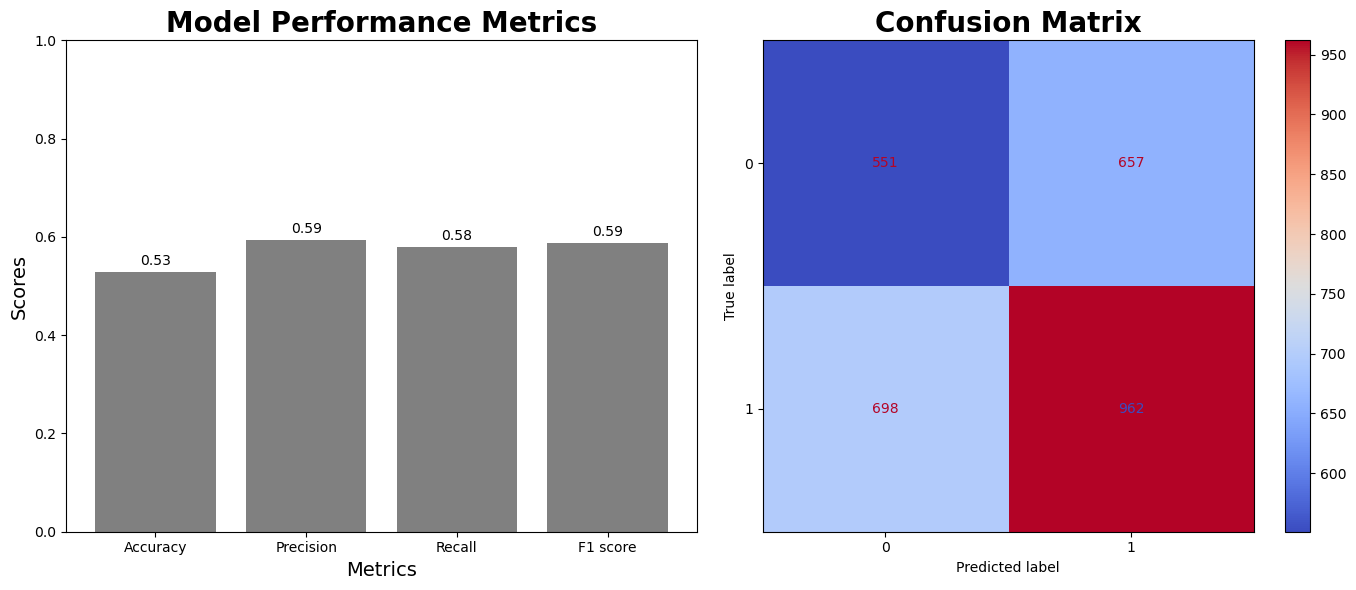

In [66]:
df5['predicted binary'] = np.where((df5['predicted return difference compared with today_corrected'] >0), 1, 0)
df5['actual binary'] = np.where(df5['real return']>0, 1, 0)
plot_model_performance(df5['predicted binary'], df5['actual binary'])

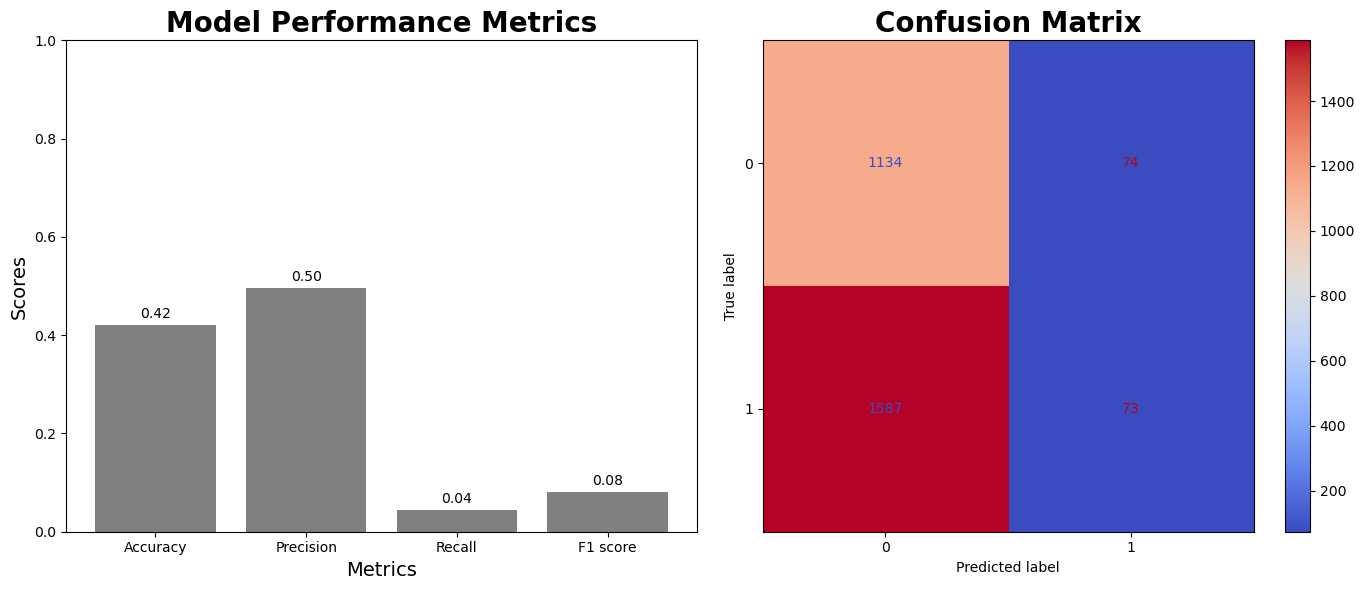

In [67]:
df5['predicted binary'] = np.where((df5['predicted return difference compared with today_corrected'] >0) & (df5['predicted return difference compared with today_corrected']>df5['threshold']), 1, 0)
# df5['predicted binary'] = np.where((df5['predicted return difference compared with today_corrected'] >0), 1, 0)
df5['actual binary'] = np.where(df5['real return']>0, 1, 0)
plot_model_performance(df5['predicted binary'], df5['actual binary'])